Just a general vibe - is the meme negative or positive? Good vibes or bad vibes, or neutral vibes

In [1]:
# loading libs
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2023-09-03 20:30:22.892373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
df = pd.read_csv('labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr', 'humour', 'sarcasm', 'offensive', 'motivational'])
df.head()	

,image_name,text_corrected,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [17]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

image_name           False
text_corrected       False
overall_sentiment    False
dtype: bool

In [18]:
# image modelling

# loading images

width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    if i in [119, 4799, 6781, 6784, 6786]:
        pass
    else:
        path = 'images/'+cleaned['image_name'][i]
        img = image.load_img(path,target_size=(width,height,3))
        img = image.img_to_array(img)
        img = img/255.0
        X.append(img)
        
X = np.array(X)

 96%|█████████▌| 6674/6987 [02:08<00:05, 54.75it/s]/Users/michal/Desktop/advanced_databases/meme_recommender/env/lib/python3.10/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 6987/6987 [02:13<00:00, 52.37it/s]


In [19]:
X.shape

(6982, 100, 100, 3)

In [20]:
rows_to_drop = ['image_120.jpg',
              'image_4800.jpg',
              'image_6782.jpg',
              'image_6785.jpg',
              'image_6787.jpg',
              'image_6988.jpg',
              'image_6989.jpg',
              'image_6990.png',
              'image_6991.jpg',
              'image_6992.jpg']

In [21]:
for images in rows_to_drop:
    cleaned.drop(cleaned[cleaned['image_name'] == images].index, inplace=True)

In [22]:
X.shape

(6982, 100, 100, 3)

In [24]:
target = cleaned['overall_sentiment']
target = pd.get_dummies(target).astype(int)
target.head()

,negative,neutral,positive,very_negative,very_positive
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,1,0,0
4,0,1,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify=target)

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


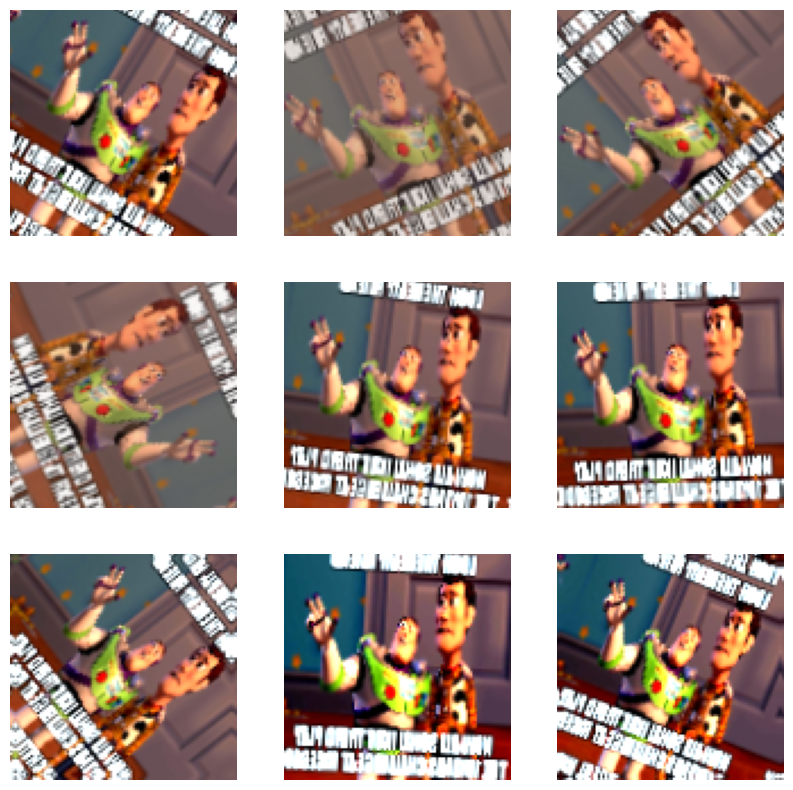

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(X)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [28]:
# base model


base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [29]:
base_model_1.trainable = False
base_model_2.trainable = False

In [30]:
def image_model():
    image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    layer_bm_1 = Dense(512)(layer_bm_1)
    layer_bm_2 = base_model_2(image_input, training=False)
    layer_bm_2 = Dense(512)(layer_bm_2)
    layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layers)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [31]:
image_input, image_layers = image_model()

In [32]:
def model(layer_1, image_input):
    semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(layer_1)

    prediction_layer = tf.keras.layers.Dense(5, activation='sigmoid', name = 'task_a')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input] , 
                           outputs = output)
    return model

In [33]:
model = model(image_layers, image_input)

In [34]:
import os
# Define the checkpoint directory to store the checkpoints
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [35]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-1
  elif epoch >= 3 and epoch < 5:
    return 1e-2
  else:
    return 1e-5

In [36]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['binary_accuracy', 'accuracy'])

history = model.fit(x = {"image_input": X_train},
                    y = y_train,
                    batch_size=256,
                    epochs=25,
                    callbacks=callbacks
                   )

Epoch 1/25


/Users/michal/Desktop/advanced_databases/meme_recommender/env/lib/python3.10/site-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


22/22 [==============================] - ETA: 0s - loss: 1.3329 - binary_accuracy: 0.6601 - accuracy: 0.4303 
Learning rate for epoch 1 is 0.10000000149011612
22/22 [==============================] - 885s 39s/step - loss: 1.3329 - binary_accuracy: 0.6601 - accuracy: 0.4303 - lr: 0.1000
Epoch 2/25
22/22 [==============================] - ETA: 0s - loss: 1.2774 - binary_accuracy: 0.5892 - accuracy: 0.4471  
Learning rate for epoch 2 is 0.10000000149011612
22/22 [==============================] - 4740s 199s/step - loss: 1.2774 - binary_accuracy: 0.5892 - accuracy: 0.4471 - lr: 0.1000
Epoch 3/25
22/22 [==============================] - ETA: 0s - loss: 1.3287 - binary_accuracy: 0.6515 - accuracy: 0.4188  
Learning rate for epoch 3 is 0.10000000149011612
22/22 [==============================] - 3641s 165s/step - loss: 1.3287 - binary_accuracy: 0.6515 - accuracy: 0.4188 - lr: 0.1000
Epoch 4/25
22/22 [==============================] - ETA: 0s - loss: 1.2745 - binary_accuracy: 0.5638 - accuracy

In [40]:
model.save("model_A.keras")


In [41]:
import keras

In [42]:
model_after_loading = keras.models.load_model('model_A.keras')